In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import matplotlib.pyplot as plt
from python.utils import read_data
from sklearn.linear_model import LinearRegression
from python.prediction import regression_task
from python.visulization import *
from python.utils import *
from tsai.all import *
import seaborn as sns
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import warnings
warnings.filterwarnings('ignore')

## Seperate Plots

In [25]:
exchanges = read_data(folder_path='../ExpData/v2/', name='returns', binary=False)
exchanges = exchanges[exchanges.index >= '2015-01-01']
cryptos = ['USDBTC', 'USDDOGE', 'USDETH', 'USDLTC', 'USDXRP']
convens = ['USDEUR', 'USDJPY', 'USDGBP', 'USDAUD', 'USDCAD', 'USDCHF', 'USDCNY', 'USDSEK', 'USDNZD']
exchanges = exchanges[cryptos+convens]

In [26]:
FOCAL = 'BTC'
LAG = 7
HORIZION = 1
SPLITS=30
LOOK_BACK=3*365+SPLITS
JUMP=30

In [9]:
# hyperparameter tunning
search_space = {
    "hidden_size": tune.grid_search([50, 100, 200]),
    "rnn_layers": tune.grid_search([1, 2 ,3]),
    "rnn_dropout": tune.grid_search([0, 0.2, 0.4, 0.8])
}

def tunning_job(config):
    model1 = MLSTM_FCN(LAG, HORIZION, 14, hidden_size=config['hidden_size'], rnn_layers=config['rnn_layers'],
               bias=True, rnn_dropout=config['rnn_dropout'], bidirectional=True)
    model2 = MLSTM_FCN(LAG, HORIZION, 5, hidden_size=config['hidden_size'], rnn_layers=config['rnn_layers'],
               bias=True, rnn_dropout=config['rnn_dropout'], bidirectional=True)
    loss_all, loss_part  = regression_task(exchanges, 'BTC', cryptos, model1, model2, HORIZION, SPLITS, LOOK_BACK, LAG, jump=JUMP)
    tune.report(mean_mae_withc=np.mean(loss_all), mean_mae_withoutc=np.mean(loss_part))

asha_scheduler = ASHAScheduler(time_attr="training_iteration", metric="mean_mae_withc", mode="min")

analysis = tune.run(tunning_job, config=search_space, name='MLSTM_FCN', scheduler=asha_scheduler,
                        stop={'training_iteration': 100}, max_failures=10, verbose=1, resume="AUTO")

2022-04-29 02:59:25,836	INFO tune.py:701 -- Total run time: 88037.27 seconds (88037.10 seconds for the tuning loop).


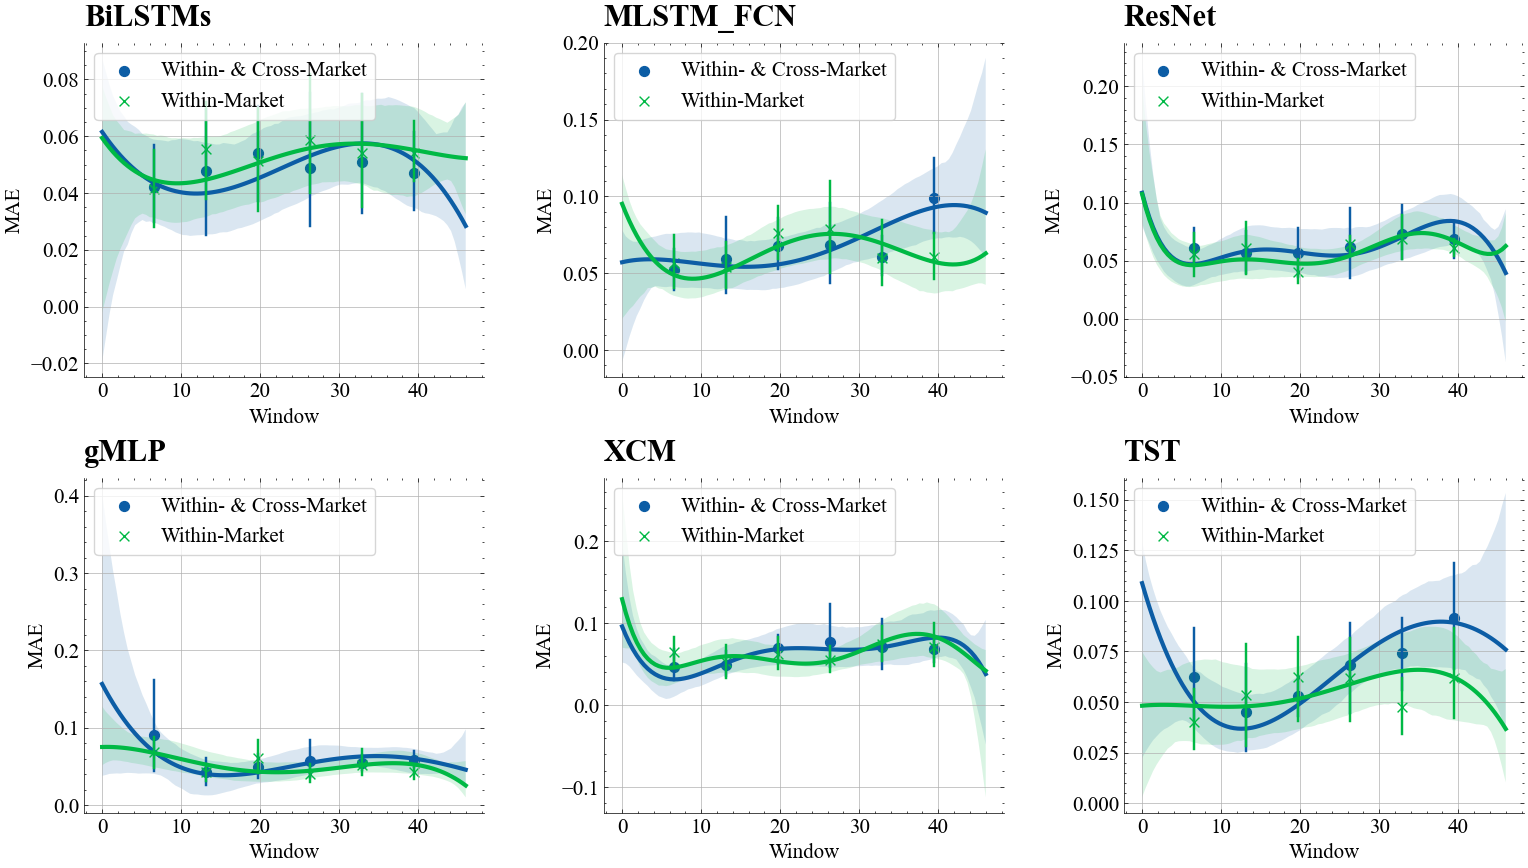

In [12]:
MLSTM_FCN = pd.read_csv('ml_res/BTC_results/result_BTC_MLSTM_FCN.csv')
BiLSTMs = pd.read_csv('ml_res/BTC_results/result_BTC_BiLSTMs.csv')
gMLP = pd.read_csv('ml_res/BTC_results/result_BTC_gMLP.csv')
ResNet = pd.read_csv('ml_res/BTC_results/result_BTC_ResNet.csv')
XCM = pd.read_csv('ml_res/BTC_results/result_BTC_XCM.csv')
TST = pd.read_csv('ml_res/BTC_results/result_BTC_TST.csv')

plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

fig, axis = plt.subplots(2, 3, dpi=100, figsize=(16,11), linewidth=10)
# models = [('BiLSTMs', BiLSTMs), ('gMLP', gMLP), ('MLSTM_FCN', MLSTM_FCN), ('ResNet', ResNet), ('XCM', XCM)]

# for i, model in enumerate(models):
hue_regplot(x='window_index', y='MAE', hue='type', data=BiLSTMs, ax=axis[0, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 0].set_title('BiLSTMs', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 0].set_xlabel('Window', size=15)
axis[0, 0].set_ylabel('MAE', size=15)
axis[0, 0].grid()
axis[0, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 0].tick_params(axis='both', which='major', labelsize=15)
# axis[0, 0].set_ylim([-1e-5, 5e-4])
# axis[0, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=MLSTM_FCN, ax=axis[0, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 1].set_title('MLSTM_FCN', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 1].set_xlabel('Window', size=15)
axis[0, 1].set_ylabel('MAE', size=15)
axis[0, 1].grid()
axis[0, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 1].tick_params(axis='both', which='major', labelsize=15)
# axis[0, 1].set_ylim([-1e-4, 6e-3])
# axis[0, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=ResNet, ax=axis[0, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[0, 2].set_title('ResNet', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 2].set_xlabel('Window', size=15)
axis[0, 2].set_ylabel('MAE', size=15)
axis[0, 2].grid()
axis[0, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 2].tick_params(axis='both', which='major', labelsize=15)
# axis[0, 2].set_ylim([-5e-5, 2.5e-3])
# axis[0, 2].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=gMLP, ax=axis[1, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 0].set_title('gMLP', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 0].set_xlabel('Window', size=15)
axis[1, 0].set_ylabel('MAE', size=15)
axis[1, 0].grid()
axis[1, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 0].tick_params(axis='both', which='major', labelsize=15)
# axis[1, 0].set_ylim([-2e-5, 1.5e-3])
# axis[1, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=XCM, ax=axis[1, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[1, 1].set_title('XCM', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 1].set_xlabel('Window', size=15)
axis[1, 1].set_ylabel('MAE', size=15)
axis[1, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 1].tick_params(axis='both', which='major', labelsize=15)
axis[1, 1].grid()
# axis[1, 1].set_ylim([-5e-5, 0.004])
# axis[1, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=TST, ax=axis[1, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 2].set_title('TST', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 2].set_xlabel('Window', size=15)
axis[1, 2].set_ylabel('MAE', size=15)
axis[1, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 2].tick_params(axis='both', which='major', labelsize=15)
axis[1, 2].grid()
# axis[1, 2].set_ylim([-5e-5, 0.004])
# axis[1, 2].set_xlim([-1, 41])

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.3)
plt.show()

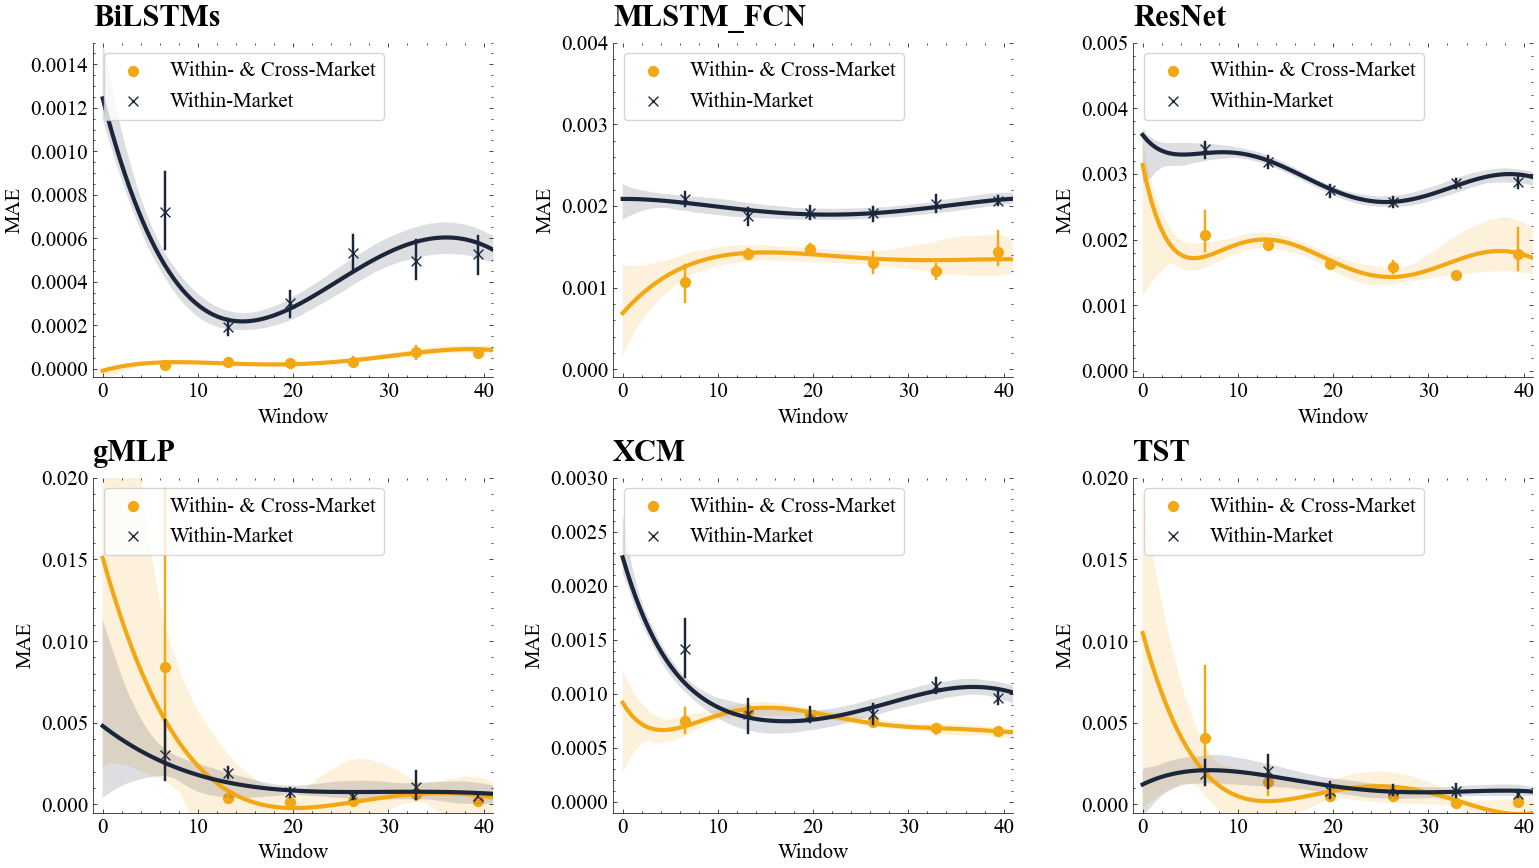

In [6]:
MLSTM_FCN = pd.read_csv('EUR_results/result_EUR_LSTM_FCN.csv')
BiLSTMs = pd.read_csv('EUR_results/result_EUR_BiLSTMs.csv')
gMLP = pd.read_csv('EUR_results/result_EUR_gMLP.csv')
ResNet = pd.read_csv('EUR_results/result_EUR_ResNet.csv')
XCM = pd.read_csv('EUR_results/result_EUR_XCM.csv')
TST = pd.read_csv('EUR_results/result_EUR_TST.csv')

plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

fig, axis = plt.subplots(2, 3, dpi=100, figsize=(16,11), linewidth=10)
# # models = [('BiLSTMs', BiLSTMs), ('gMLP', gMLP), ('MLSTM_FCN', MLSTM_FCN), ('ResNet', ResNet), ('XCM', XCM)]

# for i, model in enumerate(models):
hue_regplot(x='window_index', y='MAE', hue='type', data=BiLSTMs, ax=axis[0, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 0].set_title('BiLSTMs', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 0].set_xlabel('Window', size=15)
axis[0, 0].set_ylabel('MAE', size=15)
# axis[0, 0].grid()
axis[0, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 0].tick_params(axis='both', which='major', labelsize=15)
axis[0, 0].set_ylim([-4e-5, 1.5e-3])
axis[0, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=MLSTM_FCN, ax=axis[0, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 1].set_title('MLSTM_FCN', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 1].set_xlabel('Window', size=15)
axis[0, 1].set_ylabel('MAE', size=15)
# axis[0, 1].grid()
axis[0, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 1].tick_params(axis='both', which='major', labelsize=15)
axis[0, 1].set_ylim([-1e-4, 4e-3])
axis[0, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=ResNet, ax=axis[0, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[0, 2].set_title('ResNet', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 2].set_xlabel('Window', size=15)
axis[0, 2].set_ylabel('MAE', size=15)
# axis[0, 2].grid()
axis[0, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 2].tick_params(axis='both', which='major', labelsize=15)
axis[0, 2].set_ylim([-1e-4, 5e-3])
axis[0, 2].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=gMLP, ax=axis[1, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 0].set_title('gMLP', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 0].set_xlabel('Window', size=15)
axis[1, 0].set_ylabel('MAE', size=15)
# axis[1, 0].grid()
axis[1, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 0].tick_params(axis='both', which='major', labelsize=15)
axis[1, 0].set_ylim([-5e-4, 0.02])
axis[1, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=XCM, ax=axis[1, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[1, 1].set_title('XCM', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 1].set_xlabel('Window', size=15)
axis[1, 1].set_ylabel('MAE', size=15)
axis[1, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 1].tick_params(axis='both', which='major', labelsize=15)
# axis[1, 1].grid()
axis[1, 1].set_ylim([-1e-4, 0.003])
axis[1, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=TST, ax=axis[1, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 2].set_title('TST', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 2].set_xlabel('Window', size=15)
axis[1, 2].set_ylabel('MAE', size=15)
axis[1, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 2].tick_params(axis='both', which='major', labelsize=15)
# axis[1, 2].grid()
axis[1, 2].set_ylim([-5e-4, 0.02])
axis[1, 2].set_xlim([-1, 41])

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.3)
plt.savefig('img4.png')

In [96]:
MLSTM_FCN = pd.read_csv('AUD_results/result_AUD_MLSTM_FCN.csv')
BiLSTMs = pd.read_csv('AUD_results/result_AUD_BiLSTMs.csv')
gMLP = pd.read_csv('AUD_results/result_AUD_gMLP.csv')
ResNet = pd.read_csv('AUD_results/result_AUD_ResNet.csv')
XCM = pd.read_csv('AUD_results/result_AUD_XCM.csv')
TST = pd.read_csv('AUD_results/result_AUD_TST.csv')

plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

fig, axis = plt.subplots(2, 3, dpi=100, figsize=(16,11), linewidth=10)
# # models = [('BiLSTMs', BiLSTMs), ('gMLP', gMLP), ('MLSTM_FCN', MLSTM_FCN), ('ResNet', ResNet), ('XCM', XCM)]

# for i, model in enumerate(models):
hue_regplot(x='window_index', y='MAE', hue='type', data=BiLSTMs, ax=axis[0, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 0].set_title('BiLSTMs', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 0].set_xlabel('Window', size=15)
axis[0, 0].set_ylabel('MAE', size=15)
# axis[0, 0].grid()
axis[0, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 0].tick_params(axis='both', which='major', labelsize=15)
axis[0, 0].set_ylim([-1e-4, 3e-3])
axis[0, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=MLSTM_FCN, ax=axis[0, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[0, 1].set_title('MLSTM_FCN', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 1].set_xlabel('Window', size=15)
axis[0, 1].set_ylabel('MAE', size=15)
# axis[0, 1].grid()
axis[0, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 1].tick_params(axis='both', which='major', labelsize=15)
axis[0, 1].set_ylim([-1e-4, 3e-3])
axis[0, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=ResNet, ax=axis[0, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[0, 2].set_title('ResNet', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[0, 2].set_xlabel('Window', size=15)
axis[0, 2].set_ylabel('MAE', size=15)
# axis[0, 2].grid()
axis[0, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[0, 2].tick_params(axis='both', which='major', labelsize=15)
axis[0, 2].set_ylim([-1.5e-4, 5e-3])
axis[0, 2].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=gMLP, ax=axis[1, 0],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 0].set_title('gMLP', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 0].set_xlabel('Window', size=15)
axis[1, 0].set_ylabel('MAE', size=15)
# axis[1, 0].grid()
axis[1, 0].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 0].tick_params(axis='both', which='major', labelsize=15)
axis[1, 0].set_ylim([-1e-3, 0.04])
axis[1, 0].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=XCM, ax=axis[1, 1],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=6)
axis[1, 1].set_title('XCM', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 1].set_xlabel('Window', size=15)
axis[1, 1].set_ylabel('MAE', size=15)
axis[1, 1].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 1].tick_params(axis='both', which='major', labelsize=15)
# axis[1, 1].grid()
axis[1, 1].set_ylim([-1e-4, 3e-3])
axis[1, 1].set_xlim([-1, 41])

hue_regplot(x='window_index', y='MAE', hue='type', data=TST, ax=axis[1, 2],
        scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=6, order=4)
axis[1, 2].set_title('TST', fontweight ="bold", fontsize=22, loc='left', pad=12)
axis[1, 2].set_xlabel('Window', size=15)
axis[1, 2].set_ylabel('MAE', size=15)
axis[1, 2].legend(loc='upper left', fontsize=15, frameon=True)
axis[1, 2].tick_params(axis='both', which='major', labelsize=15)
# axis[1, 2].grid()
axis[1, 2].set_ylim([-1e-3, 0.04])
axis[1, 2].set_xlim([-1, 41])

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.3)
# plt.savefig('img4.png')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'AUD_results/result_AUD_MLSTM_FCN.csv'

## Combined Plots

In [3]:
import glob
import numpy as np
import pandas as pd

experiment_list = ['AUD', 'EUR', 'BTC', 'DOGE']

models = ['TST']

def get_results(experiment_list, models):
    df = pd.DataFrame(columns=['Window', 'within_MAE', 'cross_MAE', 'delta_MAE', 'Currency'])

    for curr in experiment_list:
        for model in models:
            file_name = glob.glob(f"ml_res/{curr}*/*{model}.csv")
            data = pd.read_csv(file_name[0])
            ap = pd.DataFrame({'within_MAE': data[data.type == 'Within-Market']['MAE'].values,
                               'cross_MAE': data[data.type == 'Within- & Cross-Market']['MAE'].values,
                               'Currency': [curr]*47, 'Window': data['window_index'][:47]})
            ap['delta_MAE'] = (ap['within_MAE'] - ap['cross_MAE'])/ap['within_MAE']
            df = pd.concat([df, ap], ignore_index=True)

    df['delta_MAE'] = df['delta_MAE'].astype(float)
    df['Window'] = df['Window'].astype(int)
    return df

In [4]:
def hue_regplot(data, x, y, hue, palette=None, markers=['o', 'x', '^', '*', 'v', 's', '>'], **kwargs):
    from matplotlib.cm import get_cmap
    regplots = []
    
    levels = data[hue].unique()
    # if palette is None:
    #     default_colors = ['#F3A712', '#1B263B', ]
    #     palette = {k: default_colors[i] for i, k in enumerate(levels)}
        
    for key, marker in zip(levels, markers):
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                marker=marker,
                label=key,
                **kwargs
            )
        )
        sns.despine()
    
    return regplots

In [79]:
df = get_results(experiment_list, ['XCM'])
np.mean(df[df.Currency == 'DOGE'].within_MAE)

0.08437923670924724

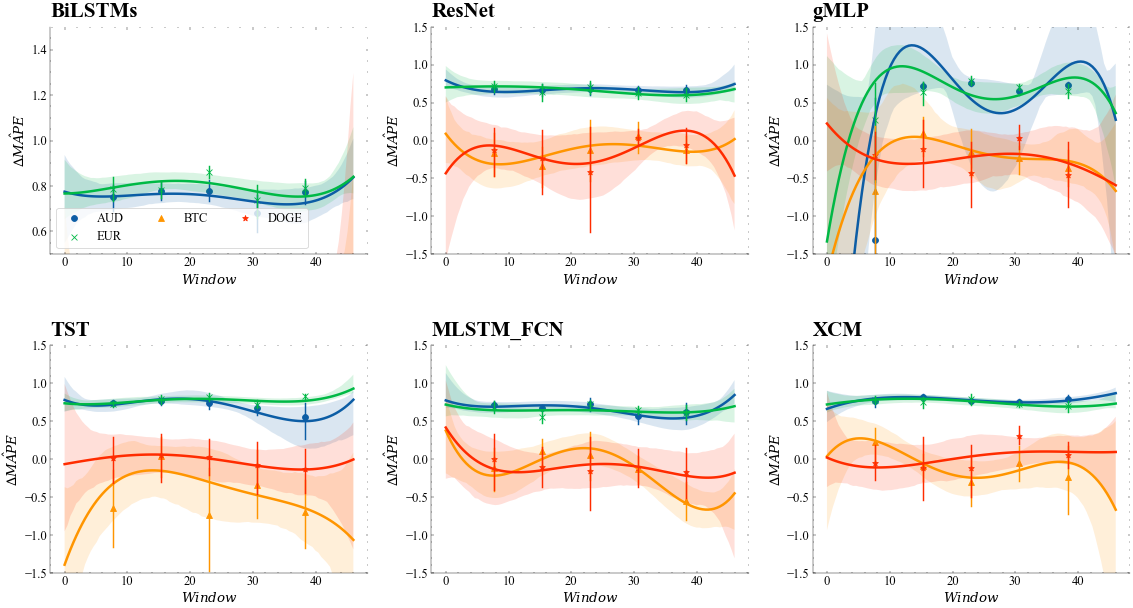

In [5]:
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = False
fig, axis = plt.subplots(2, 3, dpi=60, figsize=(20, 13), linewidth=10)

df = get_results(experiment_list, ['BiLSTMs'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 0],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 0].set_title('BiLSTMs', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 0].tick_params(axis='both', which='major', labelsize=15)
axis[0, 0].set_xlabel(r'${Window}$', size=16)
axis[0, 0].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[0, 0].set_ylim([0.5, 1.5])
axis[0, 0].legend(loc='lower left', fontsize=15, frameon=True, ncol=3)

df = get_results(experiment_list, ['ResNet'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 1],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 1].set_title('ResNet', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 1].tick_params(axis='both', which='major', labelsize=15)
axis[0, 1].set_xlabel(r'${Window}$', size=16)
axis[0, 1].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[0, 1].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['gMLP'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 2],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 2].set_title('gMLP', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 2].tick_params(axis='both', which='major', labelsize=15)
axis[0, 2].set_xlabel(r'${Window}$', size=16)
axis[0, 2].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[0, 2].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['TST'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 0],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 0].set_title('TST', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 0].tick_params(axis='both', which='major', labelsize=15)
axis[1, 0].set_xlabel(r'${Window}$', size=16)
axis[1, 0].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[1, 0].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['MLSTM_FCN'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 1],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 1].set_title('MLSTM_FCN', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 1].tick_params(axis='both', which='major', labelsize=15)
axis[1, 1].set_xlabel(r'${Window}$', size=16)
axis[1, 1].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[1, 1].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['XCM'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 2],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 2].set_title('XCM', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 2].tick_params(axis='both', which='major', labelsize=15)
axis[1, 2].set_xlabel(r'${Window}$', size=16)
axis[1, 2].set_ylabel(r'$\hat {∆MAPE}$', size=16)
axis[1, 2].set_ylim([-1.5, 1.5])

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.2, hspace=0.4)
plt.savefig('lm_results.svg')
plt.show()


## Captum

In [15]:
# ! pip install captum
from captum.attr import LayerConductance, LayerAttribution, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation, DeepLiftShap, Saliency
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

In [27]:
# train a BiLSTMs
FOCAL = 'BTC'
LAG = 7
HORIZION = 1
SPLITS=512
LOOK_BACK=2558
JUMP=30

In [28]:
focal_currency = exchanges['USD'+FOCAL].values
whole_dataset = exchanges.copy()
feature_num_full = whole_dataset.shape[1]
whole_dataset = series_to_supervised(whole_dataset, n_in=LAG, n_out=HORIZION)
whole_dataset = drop_columns(whole_dataset, exchanges, FOCAL, HORIZION)
whole_dataset = whole_dataset.values

In [12]:
# currencies = ['BTC', 'DOGE', 'ETH', 'LTC', 'XRP', 'EUR', 'JPY', 'GBP', 'AUD', 'CAD', 'CHF', 'CNY', 'SEK', 'NZD']
# new_col = []
# for curr in currencies:
#     for i in range(LAG, 0, -1):
#         new_col.append(f'{curr}(t-{i})')
# new_col.append(f'{FOCAL}(t)')
# new_dataset = whole_dataset[new_col]
# new_dataset = new_dataset.values

In [29]:
def train_model(exchanges, model, focal, SPLITS=512):
    focal_currency = exchanges['USD'+focal].values
    whole_dataset = exchanges.copy()
    feature_num_full = whole_dataset.shape[1]
    whole_dataset = series_to_supervised(whole_dataset, n_in=LAG, n_out=HORIZION)
    whole_dataset = drop_columns(whole_dataset, exchanges, focal, HORIZION)
    whole_dataset = whole_dataset.values
    
    X = whole_dataset[:, :-1].reshape((-1, LAG, feature_num_full))
    y = whole_dataset[:, -1:]
    # # to TSTensor
    X, y = TSTensor(X), TSTensor(y)
    # create the model
    # model = LSTM(LAG, HORIZION, n_layers=3, bias=True, bidirectional=True)
    # learner
    batch_tfms = TSNormalize()
    splits = TSSplitter(SPLITS)(y)
    dls = get_ts_dls(X, y, splits=splits, batch_tfms=batch_tfms)
    learner = ts_learner(dls, model, metrics=mae, verbose=False)
    # fit
    learner.fit_one_cycle(50, 1e-3)
    
    # get attr
    ig = IntegratedGradients(model)
    # ig_nt = NoiseTunnel(ig)
    dl = DeepLift(model)
    gs = GradientShap(model)
    fa = FeatureAblation(model)
    ds = DeepLiftShap(model)
    sa = Saliency(model)
    
    # sa_attr_test = sa.attribute(X)
    # print('Saliency Finished')
    # ig_attr_test = ig.attribute(X, n_steps=50)
    # print('IntegratedGradients Finished')
    # ig_nt_attr_test = ig_nt.attribute(X)
    # print('NoiseTunnel Finished')
    dl_attr_test = dl.attribute(X)
    print('DeepLift Finished')
    # gs_attr_test = gs.attribute(X[splits[1]], X[splits[0]])
    # print('GradientSHAP Finished')
    # fa_attr_test = fa.attribute(X)
    # print('FeatureAblation Finished')
    
    
    dl_attr_test = dl.attribute(X)
    x_axis_data = np.arange(X.shape[2])
    dl_attr_test = dl.attribute(X)
    
#     x_axis_data = np.arange(X.shape[2])
#     x_axis_data_labels = list(map(lambda idx: exchanges.columns[idx], x_axis_data))

#     ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0).sum(0)
#     ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

    # ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0).sum(0)
    # ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

    dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0).sum(0)
    dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

    # gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0).sum(0)
    # gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

#     fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0).sum(0)
#     fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)
    
#     sa_attr_test_sum = sa_attr_test.detach().numpy().sum(0).sum(0)
#     sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)
    
    dic = {'DeepLift': dl_attr_test_norm_sum}
    return dic

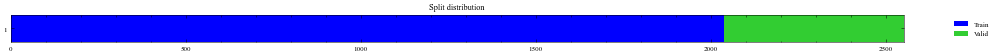

epoch,train_loss,valid_loss,mae,time
0,0.014283,0.012196,0.101030,00:01
1,0.011731,0.007815,0.077891,00:01
2,0.008306,0.003334,0.045713,00:01
3,0.005406,0.002278,0.035037,00:01
4,0.003924,0.002213,0.034190,00:01
5,0.003146,0.002213,0.034194,00:01
6,0.002776,0.002212,0.034183,00:01
7,0.002547,0.002212,0.034161,00:01
8,0.002452,0.002231,0.034312,00:01
9,0.002391,0.002223,0.034236,00:01


DeepLift Finished


In [30]:
model = LSTM(LAG, HORIZION, feature_num_full, n_layers=3, bias=True, bidirectional=True)
attr_BTC = train_model(exchanges[['USDEUR', 'USDJPY', 'USDAUD', 'USDSEK', 'USDCAD', 'USDGBP', 'USDCHF', 'USDNZD', 'USDCNY',
                                  'USDBTC', 'USDETH', 'USDLTC', 'USDDOGE', 'USDXRP']], model, focal='BTC')

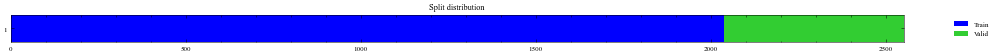

epoch,train_loss,valid_loss,mae,time
0,0.039446,0.034883,0.180407,00:01
1,0.033302,0.023967,0.147838,00:01
2,0.024620,0.010539,0.095304,00:02
3,0.015206,0.002835,0.033432,00:01
4,0.009558,0.002744,0.030082,00:01
5,0.006598,0.002675,0.028062,00:01
6,0.005116,0.002665,0.027374,00:01
7,0.004323,0.002664,0.027298,00:01
8,0.003962,0.002664,0.027294,00:01
9,0.003712,0.002691,0.028900,00:01


DeepLift Finished


In [31]:
model = LSTM(LAG, HORIZION, feature_num_full, n_layers=3, bias=True, bidirectional=True)
attr_EUR = train_model(exchanges[['USDEUR', 'USDJPY', 'USDAUD', 'USDSEK', 'USDCAD', 'USDGBP', 'USDCHF', 'USDNZD', 'USDCNY',
                                  'USDBTC', 'USDETH', 'USDLTC', 'USDDOGE', 'USDXRP']], model, focal='EUR')

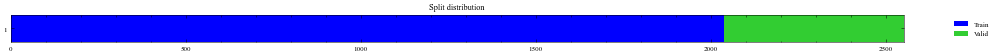

epoch,train_loss,valid_loss,mae,time
0,0.092747,0.096340,0.294220,00:01
1,0.086930,0.085366,0.275240,00:01
2,0.076902,0.066925,0.239807,00:01
3,0.060625,0.039080,0.174474,00:01
4,0.038137,0.015758,0.067523,00:01
5,0.022634,0.015768,0.065538,00:01
6,0.014482,0.015757,0.065607,00:01
7,0.010240,0.015793,0.065490,00:01
8,0.007938,0.015753,0.065631,00:01
9,0.006731,0.015732,0.065946,00:01


DeepLift Finished


In [32]:
model = LSTM(LAG, HORIZION, feature_num_full, n_layers=3, bias=True, bidirectional=True)
attr_DOGE = train_model(exchanges[['USDEUR', 'USDJPY', 'USDAUD', 'USDSEK', 'USDCAD', 'USDGBP', 'USDCHF', 'USDNZD', 'USDCNY',
                                  'USDBTC', 'USDETH', 'USDLTC', 'USDDOGE', 'USDXRP']], model, focal='DOGE')

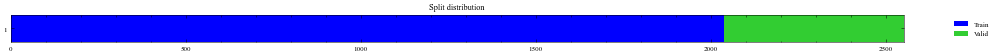

epoch,train_loss,valid_loss,mae,time
0,0.064636,0.060756,0.240734,00:01
1,0.059933,0.052107,0.222486,00:01
2,0.052283,0.038353,0.189813,00:01
3,0.040621,0.018910,0.130503,00:01
4,0.025518,0.003256,0.032127,00:01
5,0.015336,0.003235,0.031469,00:01
6,0.009970,0.003219,0.030747,00:01
7,0.007235,0.003230,0.031182,00:01
8,0.005815,0.003219,0.030750,00:01
9,0.004947,0.003262,0.032358,00:01


DeepLift Finished


In [33]:
model = LSTM(LAG, HORIZION, feature_num_full, n_layers=3, bias=True, bidirectional=True)
attr_AUD = train_model(exchanges[['USDEUR', 'USDJPY', 'USDAUD', 'USDSEK', 'USDCAD', 'USDGBP', 'USDCHF', 'USDNZD', 'USDCNY',
                                  'USDBTC', 'USDETH', 'USDLTC', 'USDDOGE', 'USDXRP']], model, focal='AUD')

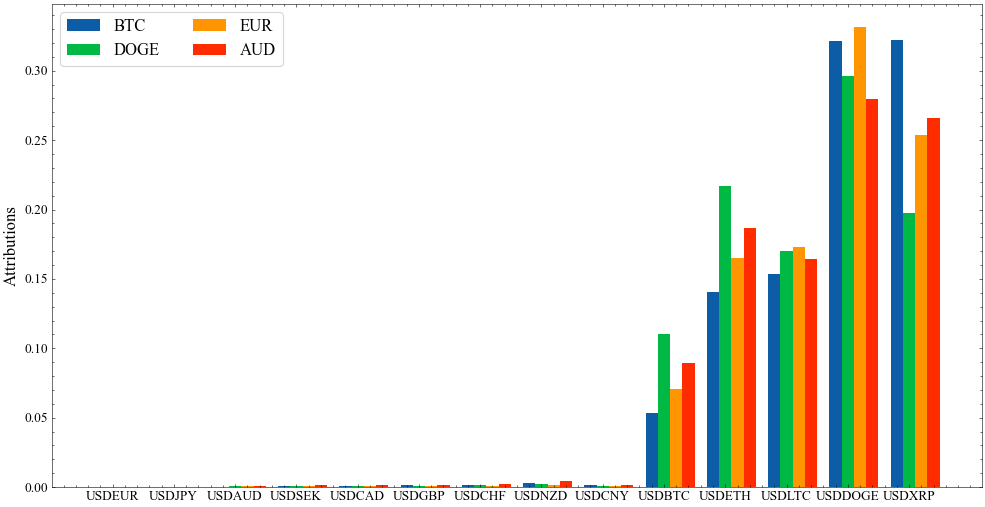

In [35]:
width = 0.2
legends = ['BTC', 'DOGE', 'EUR', 'AUD']

x_axis_data = np.array([i for i in range(14)])
x_axis_data_labels = list(map(lambda idx: exchanges[['USDEUR', 'USDJPY', 'USDAUD', 'USDSEK', 'USDCAD', 'USDGBP', 'USDCHF', 'USDNZD', 'USDCNY',
                                  'USDBTC', 'USDETH', 'USDLTC', 'USDDOGE', 'USDXRP']].columns[idx], x_axis_data))

fig, ax = plt.subplots(figsize=(15, 8), dpi=80)

ax.bar(x_axis_data, abs(attr_BTC['DeepLift']), width, align='center')
ax.bar(x_axis_data + width, abs(attr_DOGE['DeepLift']), width, align='center')
ax.bar(x_axis_data + 2*width, abs(attr_EUR['DeepLift']), width, align='center')
ax.bar(x_axis_data + 3 * width, abs(attr_AUD['DeepLift']), width, align='center')
ax.set_xticks(x_axis_data + 0.2)
ax.set_xticklabels(x_axis_data_labels)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Attributions', fontsize=15)
ax.legend(legends, loc='upper left', fontsize=15, frameon=True, ncol=2)

# ax[1, 0].set_title('EUR', fontsize=25, pad=12, fontweight ="bold", loc='left')
# # ax[1, 0].bar(x_axis_data, abs(attr_EUR['IntegratedGradients']), width, align='center')
# # ax[1, 0].bar(x_axis_data + width, abs(attr_EUR['FeatureAblation']), width, align='center')
# ax[1, 0].bar(x_axis_data, abs(attr_EUR['DeepLift']), width, align='center')
# # ax[1, 0].bar(x_axis_data + 3 * width, abs(attr_EUR['FeatureAblation']), width, align='center')
# ax[1, 0].set_xticks(x_axis_data + 0.25)
# ax[1, 0].set_xticklabels(x_axis_data_labels)
# ax[1, 0].tick_params(axis='both', which='major', labelsize=12)
# ax[1, 0].set_ylabel('Attributions', fontsize=15)

# ax[0, 1].set_title('DOGE', fontsize=25, pad=12, fontweight ="bold", loc='left')
# # ax[0, 1].bar(x_axis_data, abs(attr_DOGE['IntegratedGradients']), width, align='center')
# # ax[0, 1].bar(x_axis_data + width, abs(attr_DOGE['FeatureAblation']), width, align='center')
# ax[0, 1].bar(x_axis_data, abs(attr_DOGE['DeepLift']), width, align='center')
# # ax[0, 1].bar(x_axis_data + 3 * width, abs(attr_DOGE['FeatureAblation']), width, align='center')
# ax[0, 1].set_xticks(x_axis_data + 0.25)
# ax[0, 1].set_xticklabels(x_axis_data_labels)
# ax[0, 1].tick_params(axis='both', which='major', labelsize=12)
# ax[0, 1].set_ylabel('Attributions', fontsize=15)

# ax[1, 1].set_title('AUD', fontsize=25, pad=12, fontweight ="bold", loc='left')
# # ax[1, 1].bar(x_axis_data, abs(attr_AUD['IntegratedGradients']), width, align='center')
# # ax[1, 1].bar(x_axis_data + width, abs(attr_AUD['FeatureAblation']), width, align='center')
# ax[1, 1].bar(x_axis_data, abs(attr_AUD['DeepLift']), width, align='center')
# # ax[1, 1].bar(x_axis_data + 3 * width, abs(attr_AUD['FeatureAblation']), width, align='center')
# ax[1, 1].set_xticks(x_axis_data + 0.25)
# ax[1, 1].set_xticklabels(x_axis_data_labels)
# ax[1, 1].tick_params(axis='both', which='major', labelsize=12)
# ax[1, 1].set_ylabel('Attributions', fontsize=15)

# # plt.tight_layout()
# plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.07, hspace=0.2)
plt.savefig('captum_interpret.svg')
plt.show()

## Network

In [2]:
import pandas as pd
# re_s=pd.read_csv('/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_return_short.csv', index_col=0)
# re_m=pd.read_csv('/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_return_medium.csv', index_col=0)
# re_l=pd.read_csv('/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_return_long.csv', index_col=0)

In [3]:
cryptos = ['USDBTC', 'USDDOGE', 'USDETH', 'USDLTC', 'USDXRP']
convens = ['USDEUR', 'USDJPY', 'USDGBP', 'USDAUD', 'USDCAD', 'USDCHF', 'USDCNY', 'USDSEK', 'USDNZD']

In [1]:
def load_data():
    embedding = pd.DataFrame(columns=['Name', 'S_within_in', 'S_within_out', 'S_cross_in', 'S_cross_out',
                                  'M_within_in', 'M_within_out', 'M_cross_in', 'M_cross_out',
                                  'L_within_in', 'L_within_out', 'L_cross_in', 'L_cross_out'])
    for curr in re_s.index:
        if curr in cryptos:
            within = cryptos
            cross = convens
        else:
            within = convens
            cross = cryptos
        s_in_in = sum(re_s[within].loc[curr].values)
        s_in_out = sum(re_s[curr][within].values)
        m_in_in = sum(re_m[within].loc[curr].values)
        m_in_out = sum(re_m[curr][within].values)
        l_in_in = sum(re_l[within].loc[curr].values)
        l_in_out = sum(re_l[curr][within].values)

        s_cross_in = sum(re_s[cross].loc[curr].values)
        s_cross_out = sum(re_s[curr][cross].values)
        m_cross_in = sum(re_m[cross].loc[curr].values)
        m_cross_out = sum(re_m[curr][cross].values)
        l_cross_in = sum(re_l[cross].loc[curr].values)
        l_cross_out = sum(re_l[curr][cross].values)
        name = curr.replace('USD', '')

        embedding = embedding.append({'Name': name,
                                      'S_within_in': s_in_in, 'S_within_out': s_in_out, 'S_cross_in': s_cross_in, 'S_cross_out': s_cross_out,
                                      'M_within_in': m_in_in, 'M_within_out': m_in_out, 'M_cross_in': m_cross_in, 'M_cross_out': m_cross_out,
                                      'L_within_in': l_in_in, 'L_within_out': l_in_out, 'L_cross_in': l_cross_in, 'L_cross_out': l_cross_out,}, ignore_index=True)
    return embedding

In [82]:
from sklearn.preprocessing import MinMaxScaler
col = embedding.columns
currs = embedding['Name'].values
scaler = MinMaxScaler()
embedding = scaler.fit_transform(embedding.iloc[:,1:].to_numpy())
embedding = pd.DataFrame(embedding, columns=col[1:])
embedding['Name'] = currs

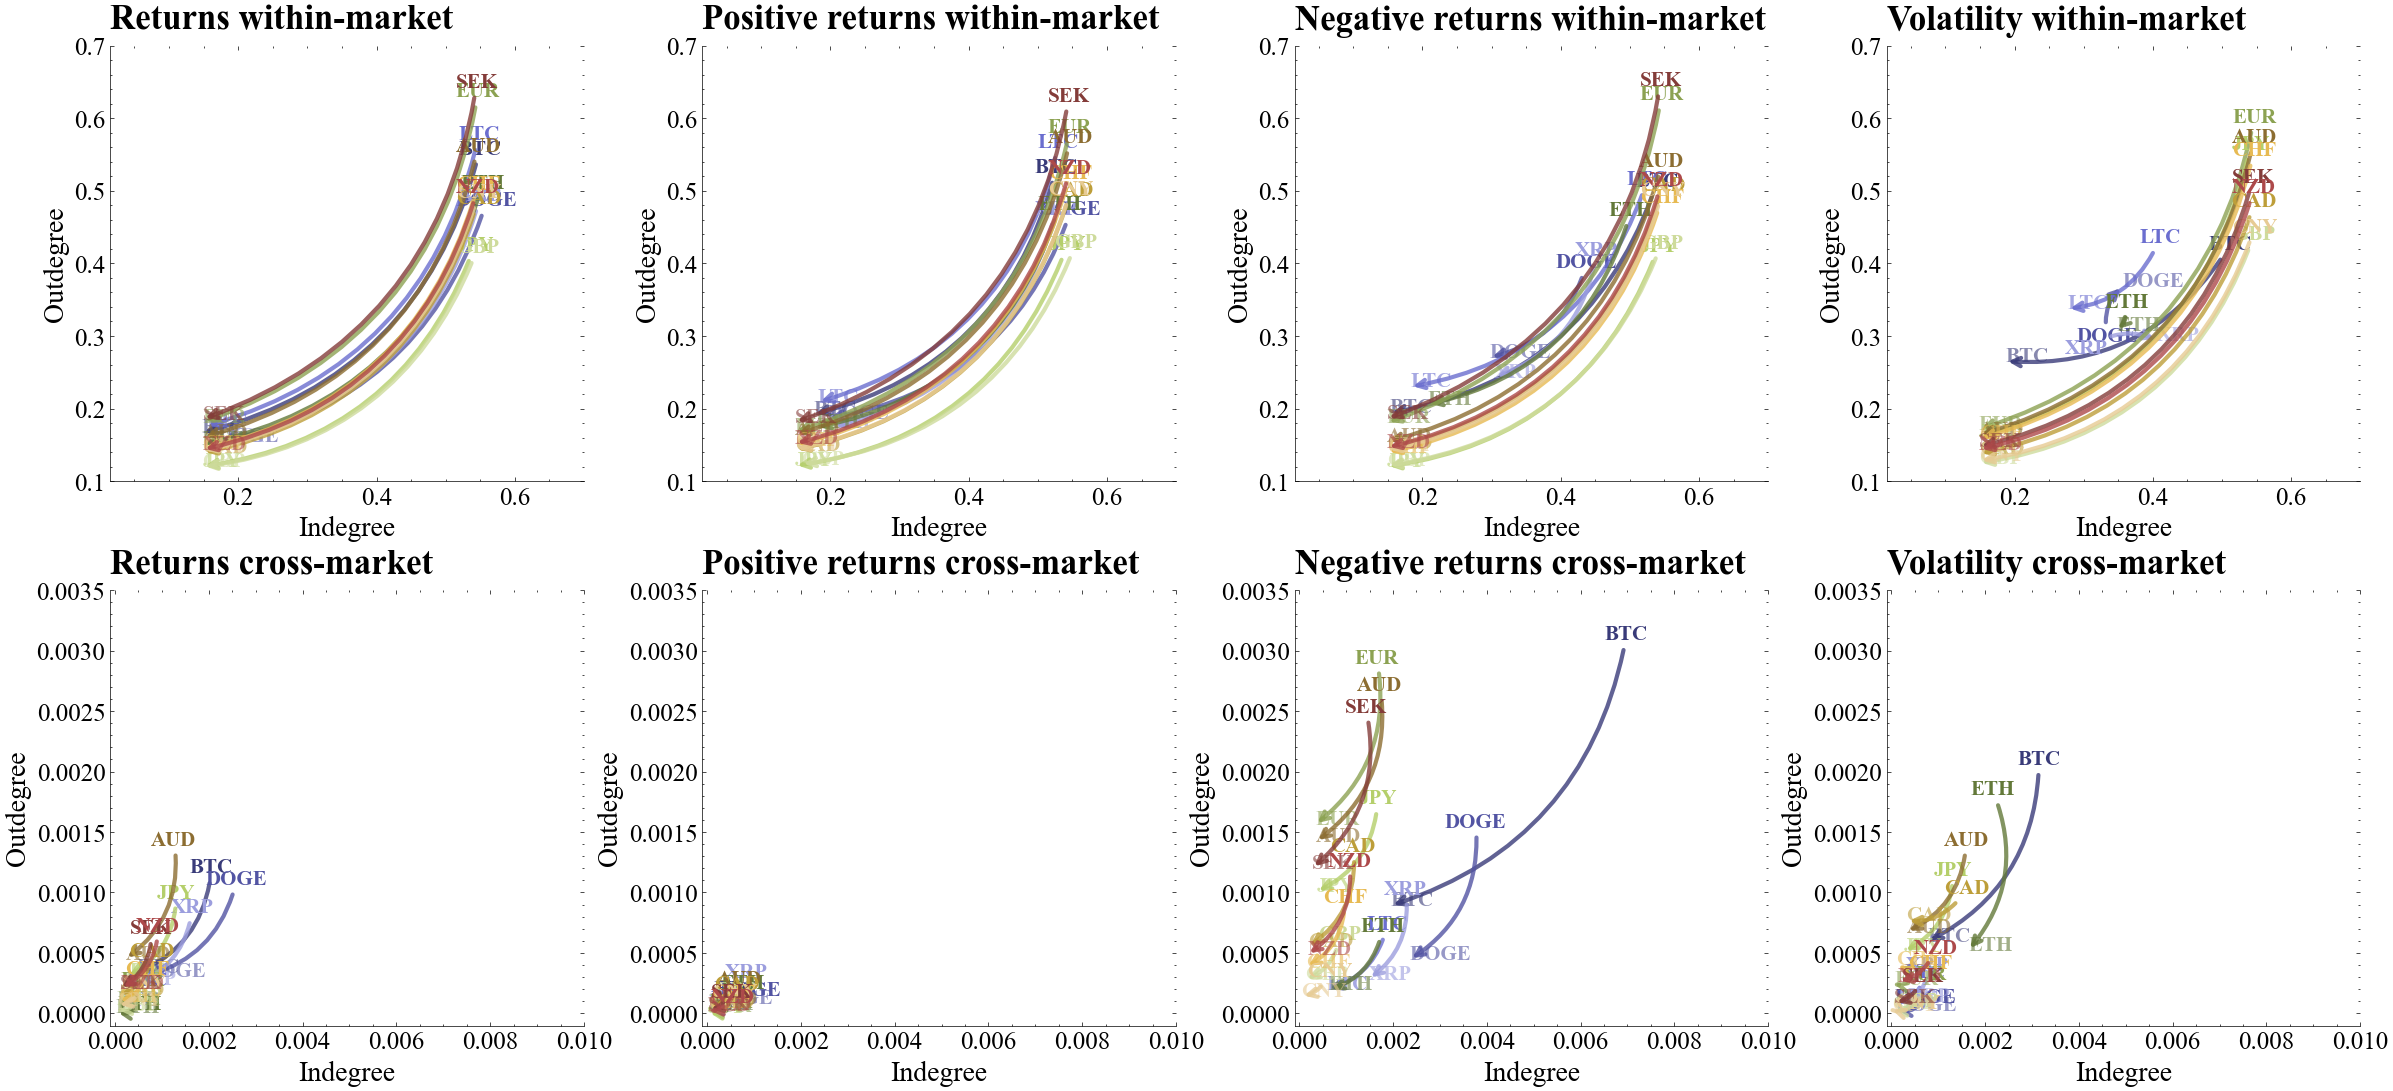

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('tab20b')

plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

fig, axis = plt.subplots(2, 4, figsize=(25, 14), dpi=100)
# axis[0].scatter(embedding['S_within_in'], embedding['S_within_out'], c=[i for i in range(14)], s=40, alpha=0)
colors = cmap.colors

names = ['return', 'preturn', 'nreturn', 'volatility']
real_labels = ['Returns', 'Positive returns', 'Negative returns', 'Volatility']
for j in range(4):
    re_s=pd.read_csv(f'/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_{names[j]}_short.csv', index_col=0)
    re_m=pd.read_csv(f'/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_{names[j]}_medium.csv', index_col=0)
    re_l=pd.read_csv(f'/Users/shiyang/Desktop/22 Spring/Essay/connectedness/conn_{names[j]}_long.csv', index_col=0)
    embedding = load_data()
    # col = embedding.columns
    # currs = embedding['Name'].values
    # scaler = MinMaxScaler()
    # embedding = scaler.fit_transform(embedding.iloc[:,1:].to_numpy())
    # embedding = pd.DataFrame(embedding, columns=col[1:])
    # embedding['Name'] = currs
    
    for i, label in enumerate(embedding['Name'].values):
        axis[0, j].set_title(f'{real_labels[j]} within-market', loc='left', fontsize=25, pad=12, fontweight ="bold")
        axis[0, j].spines['right'].set_color('none')
        axis[0, j].spines['top'].set_color('none')
        axis[0, j].annotate(label, xytext=(embedding['S_within_in'].values[i], embedding['S_within_out'].values[i]),
                         fontsize=15, weight='bold', alpha=1, color=colors[i], xy=(embedding['L_within_in'].values[i], embedding['L_within_out'].values[i]),
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=-0.3', lw=3, alpha=0.8, color=colors[i]))
        # axis[0].annotate(label, xytext=(embedding['M_within_in'].values[i], embedding['M_within_out'].values[i]),
        #                  fontsize=15, weight='bold', alpha=0.8, color=colors[i], xy=(embedding['L_within_in'].values[i], embedding['L_within_out'].values[i]),
        #                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=-0.3', lw=3, alpha=0.6, color=colors[i]))
        axis[0, j].annotate(label, (embedding['L_within_in'].values[i], embedding['L_within_out'].values[i]),
                         fontsize=15, weight='bold', alpha=0.6, color=colors[i])
        axis[0, j].set_xlim([0.015, 0.7])
        axis[0, j].set_ylim([0.1, 0.7])
        axis[0, j].tick_params(axis='both', which='major', labelsize=18)
        axis[0, j].set_ylabel('Outdegree', fontsize=20)
        axis[0, j].set_xlabel('Indegree', fontsize=20)
        axis[0, j].autoscale(enable=True, axis='both')
        
        axis[1, j].set_title(f'{real_labels[j]} cross-market', loc = 'left', fontsize=25, pad=12, fontweight ="bold")
        axis[1, j].spines['right'].set_color('none')
        axis[1, j].spines['top'].set_color('none')
        axis[1, j].annotate(label, xytext=(embedding['S_cross_in'].values[i], embedding['S_cross_out'].values[i]),
                         fontsize=15, weight='bold', alpha=1, color=colors[i], xy=(embedding['L_cross_in'].values[i], embedding['L_cross_out'].values[i]),
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=-0.3', lw=3, alpha=0.8, color=colors[i]))
        # axis[1].annotate(label, xytext=(embedding['M_cross_in'].values[i], embedding['M_cross_out'].values[i]),
        #                  fontsize=15, weight='bold', alpha=0.8, color=colors[i], xy=(embedding['L_cross_in'].values[i], embedding['L_cross_out'].values[i]),
        #                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=-0.3', lw=3, alpha=0.6, color=colors[i]))
        axis[1, j].annotate(label, (embedding['L_cross_in'].values[i], embedding['L_cross_out'].values[i]),
                         fontsize=15, weight='bold', alpha=0.6, color=colors[i])
        axis[1, j].set_xlim([-0.0001, 0.01])
        axis[1, j].set_ylim([-0.0001, 0.0035])
        axis[1, j].tick_params(axis='both', which='major', labelsize=18)
        axis[1, j].set_ylabel('Outdegree', fontsize=20)
        axis[1, j].set_xlabel('Indegree', fontsize=20)
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.savefig('frequency_currs.svg')
plt.show()

In [154]:
embedding

,Name,S_within_in,S_within_out,S_cross_in,S_cross_out,M_within_in,M_within_out,M_cross_in,M_cross_out,L_within_in,L_within_out,L_cross_in,L_cross_out


In [155]:
re_s

,USDBTC,USDDOGE,USDLTC,USDXRP,USDETH,USDEUR,USDJPY,USDGBP,USDAUD,USDCAD,USDCHF,USDCNY,USDSEK,USDNZD
USDBTC,0.237062,0.050204,1.146827e-01,4.234104e-02,7.383442e-02,0.000079,1.622946e-04,2.365288e-05,0.000361,0.000136,2.055808e-04,0.000054,2.793299e-04,0.000297
USDDOGE,0.063821,0.299491,6.781952e-02,4.480510e-02,3.851956e-02,0.000086,6.121967e-05,6.205724e-05,0.000659,0.000249,8.852695e-05,0.000086,3.157849e-04,0.000329
USDLTC,0.110942,0.051815,2.298182e-01,5.539671e-02,7.003842e-02,0.000001,1.315415e-04,3.637422e-07,0.000043,0.000012,4.437567e-06,0.000015,9.873502e-06,0.000028
USDXRP,0.054147,0.044362,7.455782e-02,2.985336e-01,4.740943e-02,0.000063,5.995659e-04,6.890621e-07,0.000318,0.000065,2.406018e-05,0.000037,5.530880e-05,0.000027
USDETH,0.084733,0.034048,8.379177e-02,4.530520e-02,2.733912e-01,0.000002,4.141472e-07,8.928534e-06,0.000012,0.000009,5.398538e-07,0.000016,9.622068e-07,0.000001
USDEUR,0.000046,0.000040,6.237943e-07,2.979258e-05,1.127265e-06,0.139022,3.308576e-02,4.535422e-02,0.052799,0.033212,6.035698e-02,0.042741,8.266067e-02,0.025502
USDJPY,0.000177,0.000050,1.467771e-04,5.216354e-04,6.096213e-07,0.061986,2.604569e-01,1.563074e-03,0.038179,0.015280,6.971017e-02,0.011803,2.439480e-02,0.030581
USDGBP,0.000025,0.000051,3.930929e-07,2.182469e-08,8.510457e-06,0.080562,1.481972e-03,2.469427e-01,0.016621,0.016450,1.668498e-02,0.059149,7.251573e-02,0.004360
USDAUD,0.000236,0.000339,2.828811e-05,1.654966e-04,6.500956e-06,0.058755,2.267753e-02,1.041245e-02,0.154704,0.062414,2.614310e-02,0.030111,5.989204e-02,0.088966
USDCAD,0.000105,0.000152,9.713516e-06,3.966315e-05,5.709672e-06,0.043612,1.070975e-02,1.216046e-02,0.073650,0.182553,2.515902e-02,0.040173,6.250833e-02,0.064015
